# Ensemble Modeling
This notebook demonstrates how **MASSpy** can be used to generate an ensemble of models. 

In [1]:
# Disable gurobi logging output for this notebook.
try:
    import gurobipy
    gurobipy.setParam("OutputFlag", 0)
except ImportError:
    pass

import logging
logging.getLogger("").setLevel("CRITICAL")

# Configure roadrunner to allow for more output rows
import roadrunner
roadrunner.Config.setValue(
    roadrunner.Config.MAX_OUTPUT_ROWS, 1e6)

from mass import MassConfiguration, Simulation
from mass.test import create_test_model

mass_config = MassConfiguration()
mass_config.decimal_precision = 12 # Round 12 places after decimal

# Load the model
reference_model = create_test_model("Glycolysis")

Academic license - for non-commercial use only


## Generating Data for Ensembles

In addition to loading external sources of data for use (e.g. loading excel sheets), sampling can be used to get valid data for the generation of ensembles. As an example, a small set of samples are generated for use in this notebook.

Utilizing [COBRApy flux sampling](https://cobrapy.readthedocs.io/en/latest/sampling.html#), the following flux samples are used in generating the ensemble of models. All steady state flux values are set to allow to deviation by up to 50% of their defined baseline values.

In [2]:
from cobra.sampling import sample

In [3]:
for reaction in reference_model.reactions:
    flux = reaction.steady_state_flux
    reaction.bounds = sorted([
        round(flux * 0.5, 12), round(flux * 1.5, 12)])
    
flux_samples = sample(reference_model, n=10, seed=25)

Utilizing [MASSpy concentration sampling](./thermo_concentrations.ipynb#Concentration-Sampling), the following concentration samples are used in generating the ensemble of models. All concentration value are set to allow to deviation by up to 80% of their defined baseline values.

In [4]:
from mass.thermo import ConcSolver, sample_concentrations

In [5]:
conc_solver = ConcSolver(
    reference_model,
    excluded_metabolites=["h_c", "h2o_c"],
    equilibrium_reactions=["ADK1"],
    constraint_buffer=1e-7)

conc_solver.setup_sampling_problem(
    conc_percent_deviation=0.8,
    Keq_percent_deviation=0)

conc_samples = sample_concentrations(conc_solver, n=8, seed=25)

Because there are 10 flux data sets and 8 concentration data sets being passed to the function, there are $10 * 8 = 80$ models generated in total.

## Creating an Ensemble

In [6]:
from mass.simulation import ensemble, generate_ensemble_of_models

### Generating new models

The `ensemble` submodule has two functions for creating models from `pandas.DataFrame` objects.

* The `create_models_from_flux_data()` function creates an ensemble of models from a `DataFrame` containing flux data, where rows correspond to samples and columns correspond to reaction identifiers.
* The `create_models_from_concentration_data()` function creates an ensemble of models from a `DataFrame` containing concentration data, where rows correspond to samples and columns correspond to metabolite identifiers.

The functions can be used seperately or together to generate models. In this example, an ensemble of 80 models is generated by utilizing both modle generation methods. 

First, the 10 flux samples are used to generate 10 models with varying flux states from a single reference `MassModel`.

In [7]:
flux_models = ensemble.create_models_from_flux_data(
    reference_model, data=flux_samples)
len(flux_models)

10

Treating each of the 10 models with varying flux states as a reference model, the `list` of models can be passed to the `create_models_from_concentration_data` along with the 8 concentration samples to create 8 models with varying concentration states per flux state, giving a total of 80 models generated.

In [8]:
conc_models = []
for ref_model in flux_models:
    conc_models += ensemble.create_models_from_concentration_data(
        ref_model, data=conc_samples)
len(conc_models)

80

Generating the models does not always ensure that the models are thermodynamically feasible. The `ensure_positive_percs()` function can be used ensure all reactions passed to the `reactions` argument produce positive PERCs for each provided model. Those that produce all positive PERCs are seperated from those that produce at least one negative PERC, and the two lists are returned.

If the `update_values` argument is set to `True`, model PERC values are updated for models that produce all positive PERCs.

In [9]:
# Exclude boundary reactions from PERC calculations for the example
reactions_to_check_percs = [
    r.id for r in reference_model.reactions
    if r not in reference_model.boundary]

positive, negative = ensemble.ensure_positive_percs(
    models=conc_models, reactions=reactions_to_check_percs, 
    update_values=True)

print("Models with positive PERCs: {0}".format(len(positive)))
print("Models with negative PERCs: {0}".format(len(negative)))

Models with positive PERCs: 80
Models with negative PERCs: 0


To ensure that all generated models can reach a steady state, the `ensure_steady_state()` function can be used. If the `update_values` argument is set to `True`, models that can reach a steady state  values are updated with the steady state values.

In [10]:
feasible, infeasible = ensemble.ensure_steady_state(
    models=positive, strategy="simulate",
    update_values=True, decimal_precision=True)

print("Reached steady state: {0}".format(len(feasible)))
print("No steady state reached: {0}".format(len(infeasible)))

Reached steady state: 80
No steady state reached: 0


The `perturbations` argument of the `ensure_steady_state()` method can be used to ensure that models can reach a steady state with a given perturbation. 

In [11]:
feasible, infeasible = ensemble.ensure_steady_state(
    models=feasible, strategy="simulate",
    perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    update_values=False)

print("Reached steady state: {0}".format(len(feasible)))
print("No steady state reached: {0}".format(len(infeasible)))

mass/simulation/simulation.py:819 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


Reached steady state: 75
No steady state reached: 5


All of the models that were returned as successful are considered thermodynamically feasible and were able to reach a steady state, even with the given disturbance.

## Simulating an Ensemble of Models

Once an ensemble of models has been generated, the `Simulation` object can be used to simulate the ensemble of models.

In [12]:
sim = Simulation(reference_model, verbose=True)

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


To add an additional model to an existing `Simulation` object, three criteria must be met:

1. The model must have equivalent ODEs to the `reference_model` used in creating the `Simulation`.
2. All models in the `Simulation` must have unique identifiers
3. Numerical values that are necessary for simulation must already be defined for a model.

To load the additional models into the `Simulation`, the `Simulation.add_models()` method is used.

In [13]:
sim.add_models(models=feasible)
print("Number of models added: {0}".format(len(feasible)))
print("Number of models total: {0}".format(len(sim.models)))

Number of models added: 75
Number of models total: 76


To simulate multiple models, the `simulate()` method can be used. By default, the `simulate()` method will simulate all models loaded into the `Simulation`, including the reference model.

In [14]:
conc_sol_list, flux_sol_list = sim.simulate(time=(0, 1000))
print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

ConcSols returned: 76
FluxSols returned: 76


To simulate a subset of the models, a list of models or model identifiers can be provided to the `simulate()` method. For example, to simulate the subset of models with an identical concentration state but different flux states:

In [15]:
model_subset = [model for model in sim.models if model.endswith("_C0")]
conc_sol_list, flux_sol_list = sim.simulate(
    models=model_subset, time=(0, 1000))
print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

ConcSols returned: 9
FluxSols returned: 9


Similar to the `simulate()` method, the `find_steady_state()` method can be used to find the steady state for an ensemble of models or a subset of models.

In [16]:
conc_sol_list, flux_sol_list = sim.find_steady_state(
    models=model_subset, strategy="simulate")
print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

ConcSols returned: 9
FluxSols returned: 9


If a failure occurs for a model during a steady state determination or a simulation (e.g. no steady state exists), the `MassSolution` objects that correspond to the failed model will be returned empty.

In [17]:
# Create a simulation with the reference model and an infeasible one 
infeasible_sim = Simulation(reference_model)
infeasible_sim.add_models(infeasible[0])

conc_sol_list, flux_sol_list = infeasible_sim.find_steady_state(
    strategy="simulate", perturbations={"kf_ATPM": "kf_ATPM * 1.5"})

print("ConcSols returned: {0}".format(len(conc_sol_list)))
print("FluxSols returned: {0}".format(len(flux_sol_list)))

for model, sol in zip(sim.models, conc_sol_list):
    print("Solutions for {0}: {1}".format(str(model), bool(sol)))

ConcSols returned: 2
FluxSols returned: 2
Solutions for Glycolysis: True
Solutions for Glycolysis_F0_C0: False


### Visualizing Ensemble Results

If the visualization feature of **MASSPy** are enabled, the results of simulating the ensemble can be visualized using the `plot_ensemble_time_profile()` and `plot_ensemble_phase_portrait()` functions.

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)

A list of `MassSolution` objects is required to use an ensemble visualization function. The output of `simulate()` method for an ensemble of models can be placed into the functions directly.

In [19]:
sim = Simulation(reference_model, verbose=True)
sim.add_models(models=feasible)

conc_sol_list, flux_sol_list = sim.simulate(
    models=feasible, time=(0, 1000), perturbations={"kf_ATPM": "kf_ATPM * 1.5"},
    decimal_precision=True)

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


The `plot_ensemble_time_profile()` function works in a very similar manner as the `plot_time_profile()` function described in [Time Profiles](./plot_visualization.ipynb#Time-Profiles). The minimal input required is a list of `MassSolution` objects and an iterable containing strings or objects with identifiers that correspond to keys of the `MassSolution`. The plotted solution lines represent the average (mean) solution.

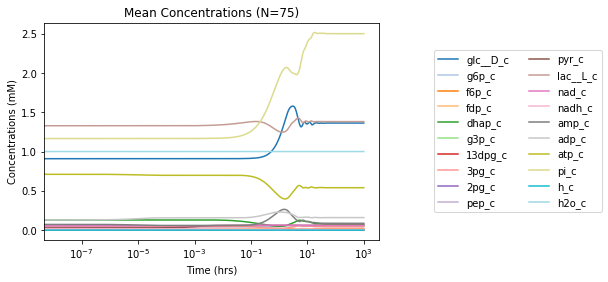

In [20]:
plot_ensemble_time_profile(
    conc_sol_list, observable=reference_model.metabolites, interval_type=None,
    legend="right outside", plot_function="semilogx",
    xlabel="Time (hrs)", ylabel="Concentrations (mM)",
    title="Mean Concentrations (N={0})".format(len(conc_sol_list)))

Because the plotted lines represent the mean solution values over time for the ensemble, there will be some uncertainty associated with the solutions. The `interval_type` argument can be specified to plot the results for a specified confidence interval. For example, to plot the mean PYK flux with a 95% confidence interval:

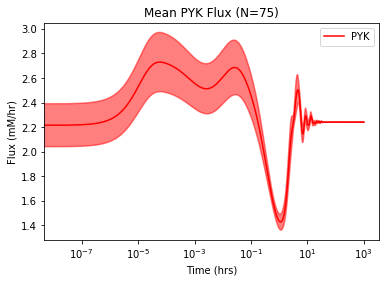

In [21]:
plot_ensemble_time_profile(
    flux_sol_list, observable=["PYK"], legend="best", 
    interval_type="CI=95", # Shading for 95% confidence
    plot_function="semilogx", xlabel="Time (hrs)",
    ylabel="Flux (mM/hr)",
    title="Mean PYK Flux (N={0})".format(len(flux_sol_list)),
    color="red", mean_line_alpha=1,  # Default opacity of mean line
    interval_fill_alpha=0.5,   # Default opacity for interval shading
    interval_border_alpha=0.5)  # Default opacity of border lines


Setting  `interval_type="range"` will shade between the minimum and maximum solution values. The `mean_line_alpha`, `interval_fill_alpha`, and `interval_border_alpha` kwargs are used to control the opacity of the mean solution, interval borders, and interval shading.

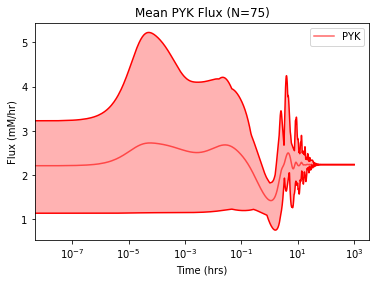

In [22]:
plot_ensemble_time_profile(
    flux_sol_list, observable=["PYK"], interval_type="range", # Shading from min to max value
    legend="best", plot_function="semilogx",
    xlabel="Time (hrs)", ylabel="Flux (mM/hr)",
    title="Mean PYK Flux (N={0})".format(len(flux_sol_list)),
    color="red", mean_line_alpha=0.6,  # For opacity of mean line
    interval_fill_alpha=0.3, # For lighter interval shading
    interval_border_alpha=1  # For darker border lines
)

Relative deviations can also be plotted using the `deviation` kwarg. The `deviation_zero_centered` kwarg is used to shift the results to deviate from 0, and the `deviation_normalization` kwarg is used to normalize each solution.

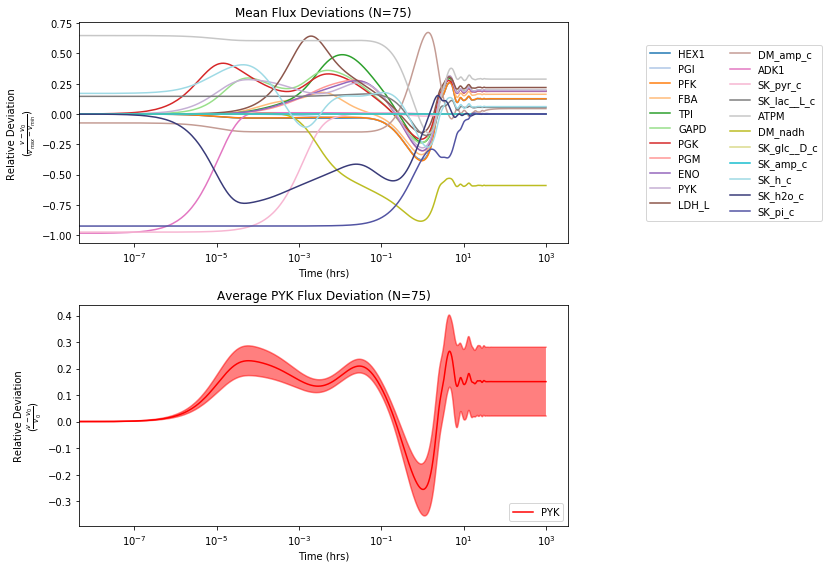

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Plot all relative flux deviations
plot_ensemble_time_profile(
    flux_sol_list, observable=reference_model.reactions,
    ax=ax1, legend="right outside",  interval_type=None,
    plot_function="semilogx", xlabel="Time (hrs)",
    ylabel=("Relative Deviation\n" +\
            r"($\frac{v - v_{0}}{v_{max} - v_{min}}$)"),
    title="Mean Flux Deviations (N={0})".format(len(flux_sol_list)),
    deviation=True, deviation_zero_centered=True,  # Center around 0
    deviation_normalization="range")  # Normalized by value range

# Plot PYK relative flux deviations
plot_ensemble_time_profile(
    flux_sol_list, observable=["PYK"],
    ax=ax2, legend="lower right", interval_type="CI=99",  # 99% confidence interval
    plot_function="semilogx", xlabel="Time (hrs)",
    ylabel=("Relative Deviation\n" +\
            r"($\frac{v - v_{0}}{v_{0}}$)"),
    title="Average PYK Flux Deviation (N={0})".format(len(flux_sol_list)),
    color="red", deviation=True,
    deviation_zero_centered=True,  # Center around 0
    deviation_normalization="initial value")  # Normalized by initial value

fig.tight_layout()

The `plot_ensemble_phase_portrait()` function works in a very similar manner as the `plot_phase_portrait()` function  described in [Phase Portraits](./plot_visualization.ipynb#Phase-Portraits). The `plot_ensemble_phase_portrait()` function plots the mean solution of the two ensemble simulation results against one another.

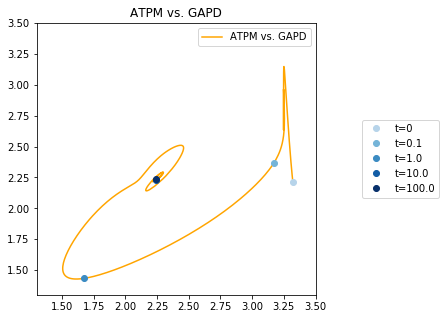

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# Createt time points and colors for the time points
time_points = [0, 1e-1, 1e0, 1e1, 1e2]
time_point_colors = [
    mpl.colors.to_hex(c)
    for c in mpl.cm.Blues(np.linspace(0.3, 1, len(time_points)))]

# Plot the phase portrait
plot_ensemble_phase_portrait(
    flux_sol_list, x="ATPM", y="GAPD", ax=ax, legend="upper right",
    xlim=(1.3, 3.5), ylim=(1.3, 3.5),
    title="ATPM vs. GAPD",
    color="orange", linestyle="-",
    annotate_time_points=time_points,
    annotate_time_points_color=time_point_colors,
    annotate_time_points_legend="right outside");

## Fast Ensemble Creation

Perhaps the easiest way of generating an ensemble of models is to utilize the `generate_ensemble_of_models()` function. The `generate_ensemble_of_models()` function has been built for performance and therefore, provides less control over the ensemble generation process and has a setup time associated with it. However, for the generation of large ensembles, this may be a more desirable method.

This function utilizes a single `MassModel` as a reference model, and then utilizes data provided as a `pandas.DataFrame` for the `flux_data` and `conc_data` arguments. 

* For `flux_data`, the columns are the reaction identifiers where each value represents the steady state flux of the reaction for the data set given by each row.
* For `conc_data`, the columns are the metabolite identifiers where each value represents the concentration/initial condition of the metabolite for the data set given by each row.

At least one of the above arguments must be passed to the function. After generating models, a list containing the models is returned.

In [25]:
# Generate the ensemble
models = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples)

Total models generated: 80


To ensure that the PERCs for certain reactions are positive, a `list` of reactions to check can be passed to the `ensure_positive_percs` argument. 

In [26]:
# Exclude boundary reactions from PERC calculations for the example
reactions_to_check_percs = [
    r.id for r in reference_model.reactions
    if r not in reference_model.boundary]

# Generate the ensemble
ensemble = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples,
    ensure_positive_percs=reactions_to_check_percs)

Total models generated: 80
Feasible: 80
Infeasible, negative PERCs: 0


To ensure that all models can reach a steady state with their new values, a strategy for finding the steady state can be passed to the `strategy` argument. 

In [27]:
# Generate the ensemble
models = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples,
    ensure_positive_percs=reactions_to_check_percs,
    strategy="simulate")

Total models generated: 80
Feasible: 80
Infeasible, negative PERCs: 0
Infeasible, no steady state found: 0


To ensure that all models can reach a steady state with their new values after a given perturbation, in addition to passing a value to the `strategy` argument, one or more perturbations can be given to the `perturbations` argument. The `perturbations` argument takes a `list` of `dict` objects containing the perturbations as described in [Dynamic Simulation](./dynamic_simulation.ipynb#Perturbing-a-Model).

If it is desirable to return the models that were not deemed 'feasible', the `return_infeasible` kwarg can be set to `True` to generate and return a second list containing only models deemed 'infeasible'.

In [28]:
feasible, infeasible = generate_ensemble_of_models(
    reference_model=reference_model, 
    flux_data=flux_samples,
    conc_data=conc_samples,
    ensure_positive_percs=reactions_to_check_percs,
    strategy="simulate",
    perturbations=[
        {"kf_ATPM": "kf_ATPM * 1.5"},
        {"kf_ATPM": "kf_ATPM * 0.85"}],
    return_infeasible=True)

mass/simulation/simulation.py:819 UserWarning: Unable to find a steady state for one or more models. Check the log for more details.


Total models generated: 80
Feasible: 75
Infeasible, negative PERCs: 0
Infeasible, no steady state found: 0
Infeasible, no steady state with pertubration 1: 5
Infeasible, no steady state with pertubration 2: 0


Note that perturbations are not applied all at once; each `dict` provided corresponds to a new attempt to find a steady state. For example, two dictionaries passed to the `perturbations` argument indicate that 3 steady state determinations are performed, once for the model without any pertubrations and once for each `dict` passed.

In general, it is recommended to utilize the functions in the `ensemble` submodule to generate small ensembles while experimenting with various settings, and then to utilize the `generate_ensemble_of_models` function to generate the larger ensemble.